## tendigit1

<Axes: >

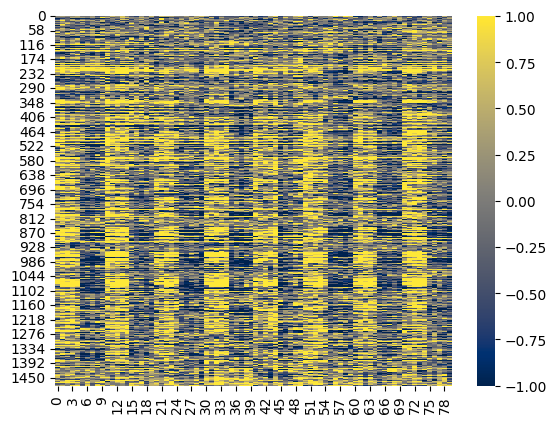

In [8]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

# load the .mat fMRI file:
mat = scipy.io.loadmat('analysis/TD1/reg_data_run.mat')

# get and prewhiten the beta:
beta = mat['beta'] / np.sqrt(mat['ResMs'])

# get the voxel info:
subj_name=['s01','s02','s03','s04','s05','s06']
run=['01','02','03','04','05','06','07','08']
hem=['lh','rh']
regname=['S1','M1','PMd','PMv','SMA','V12','AIP','OPJ']
# hem={'lh','rh'};
# regname={'S1','M1','PM','SMA','SPL','handM1'};

sn = mat['SN'].flatten()
regNum = mat['regNum'].flatten()

# make the regressor info:
run = np.repeat(np.arange(1,9), 10)
hand = np.tile(np.array([1,1,1,1,1,2,2,2,2,2]),8) # 1=left, 2=right
digit = np.tile(np.array([1,2,3,4,5,1,2,3,4,5]),8) # 1=thumb, 5=little finger

# colormap of beta:
beta1 = beta[(sn==1) & (regNum==7)]
# beta1 = beta1[:,run==1]
sns.heatmap(beta1, cmap='cividis', vmin=-1, vmax=1)



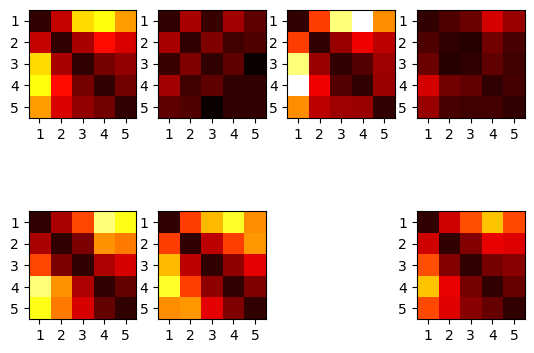

In [9]:
S1 = 1
M1 = 2
PM = 3
SMA = 4
SPL = 5
handM1 = 6

reg = M1
beta = mat['beta'] / np.sqrt(mat['ResMs'])

# Estimate the cross-val G for each subject:
N = np.unique(sn).shape[0]
G_hat = np.zeros((N, 5, 5))
D_hat = np.zeros((N, 5, 5))
for i in range(N):
    for j in range(2):
        beta_hand = beta[:,hand==j+1]
        digit = np.tile(np.array([1,2,3,4,5]),8)
        run = np.repeat(np.arange(1,9), 5)
        
        Y = beta_hand[(sn==i+1) & (regNum==((1-j)*6+reg))].T
        G_hat_tmp,_ = pcm.est_G_crossval(Y,digit,run,X=pcm.matrix.indicator(run))
        G_hat[i,:,:] = G_hat[i,:,:] + G_hat_tmp/2
        D_hat[i,:,:] = D_hat[i,:,:] + pcm.G_to_dist(G_hat_tmp)/2

# show all second moment matrices
vmin = D_hat.min()
vmax = D_hat.max()
for i in range(N):
    plt.subplot(2,4,i+1)
    plt.imshow(D_hat[i,:,:],vmin=vmin,vmax=vmax,cmap='hot')
    plt.xticks(np.arange(5),['1','2','3','4','5'])
    plt.yticks(np.arange(5),['1','2','3','4','5'])

# show the average second moment matrix
plt.subplot(2,4,8)
plt.imshow(D_hat.mean(axis=0),vmin=vmin,vmax=vmax,cmap='hot')
plt.xticks(np.arange(5),['1','2','3','4','5'])
plt.yticks(np.arange(5),['1','2','3','4','5'])

plt.show()

## ExtensionFlexion

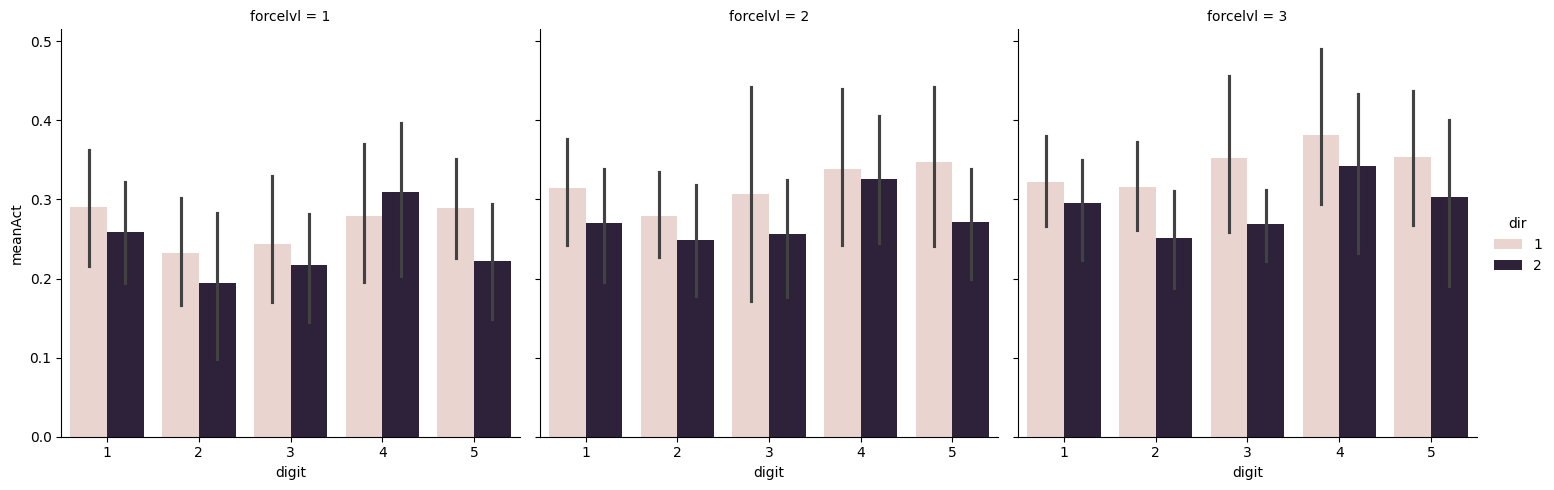

In [ ]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

# direction  = {'flex','ext'};    # 1=flexion, 2=extension
# cond_forces= {[1.5 2 2.5],[1 1.5 2]};
# dirTT      = {[1:15],[16:30]};  # condition numbers corresponding to flexion and extension movements
# digitName  = {'thumb','index','middle','fourth','little'};  
# hem        = {'lh','rh'};       # 1 = left hemi (contra) , 2 = right hemi (ipsi)
# regname    = {'S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp'};             # roi names    

# reg_title  = {'Lh S1','Lh M1','Lh PMd','Lh PMv','Lh SMA','Lh V1','Lh SPLa','Lh SPLp',...
#               'Rh S1','Rh M1','Rh PMd','Rh PMv','Rh SMA','Rh V1','Rh SPLa','Rh SPLp'}; 

# load the .mat fMRI file:
mat = scipy.io.loadmat('analysis/EF/ef1_fmri_glm1_reg_betas.mat')
info = scipy.io.loadmat('analysis/EF/SPM_info.mat')

beta_cell = mat['beta']
res_MS_cell = mat['resMS']

# regions:
S1 = 1
M1 = 2
PMd = 3
PMv = 4
SMA = 5
V12 = 6
SPLa = 7
SPLp = 8

# conditions:
run = info['run'].flatten()
digit = info['digitPressed'].flatten()
dir = info['dirPressed'].flatten() # 1: flexion, 2: extension
forcelvl = info['forcelvl'].flatten() # 1: 1.5, 2: 2, 3: 2.5

# voxel info:
sn = mat['SN']
region = mat['region']
N = np.unique(sn).shape[0]

# signal change for flexion/extension + force level + digit:
reg = M1

data = []
# loop on subj:
for i in range(N):
    # loop on dir:
    for j in range(2):
        # loop on force level:
        for k in range(3):
            # loop on digit:
            for l in range(5):
                # subj data:
                beta = beta_cell[(region==reg) & (sn==i+1)][0] / np.sqrt(res_MS_cell[(region==reg) & (sn==i+1)][0])
                beta = beta[:240,:]
                
                # select condition:
                beta = beta[(dir==j+1) & (forcelvl==k+1) & (digit==l+1),:]

                # mean activity:
                meanAct = np.mean(beta)

                # add to dataframe:
                data.append({'sn': i + 1, 'digit': l + 1, 'dir': j + 1, 'forcelvl': k + 1, 'meanAct': meanAct})         

df = pd.DataFrame(data)
# plot the data:
sns.catplot(x='digit',y='meanAct',hue='dir',col='forcelvl',data=df,kind='bar')
plt.show()



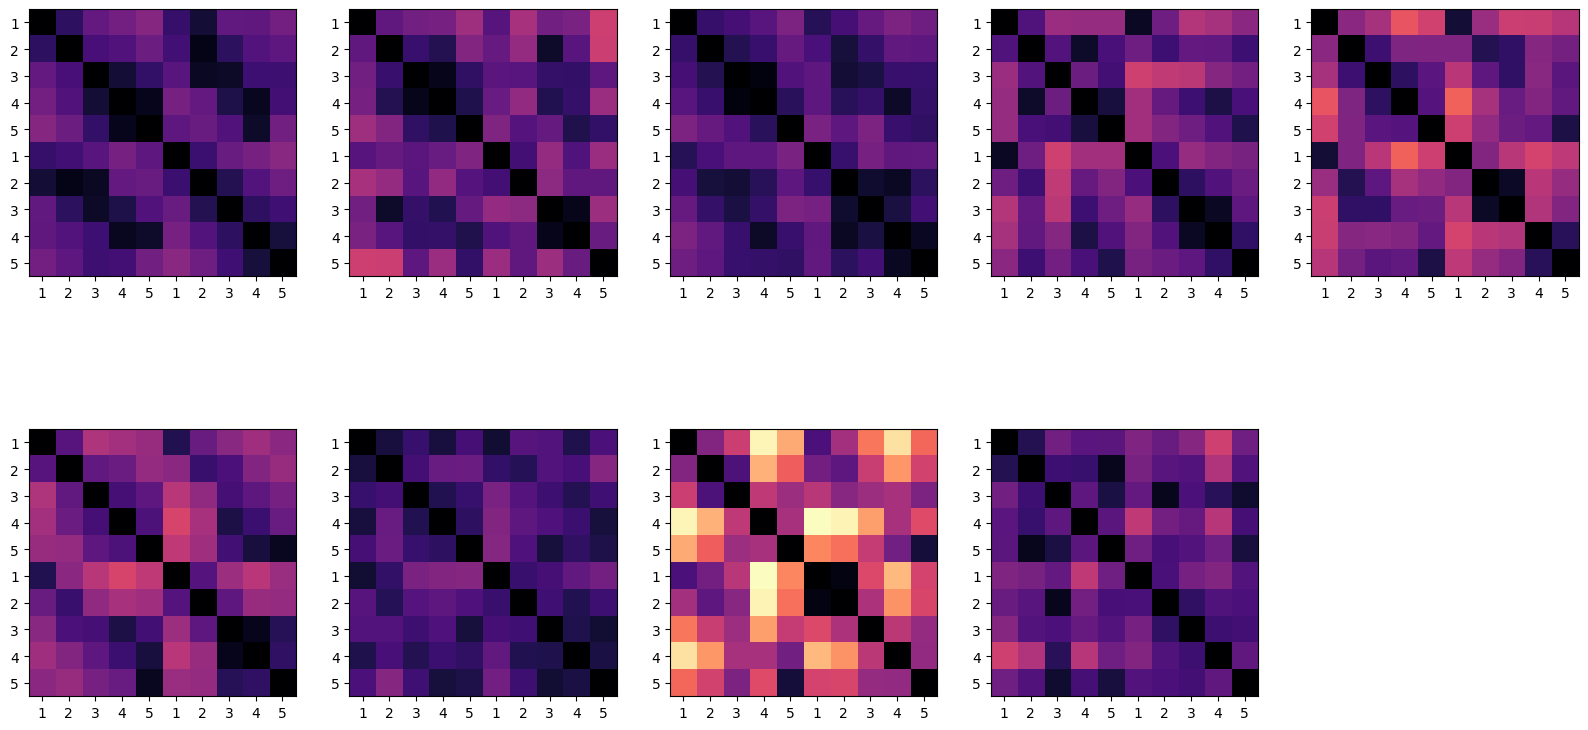

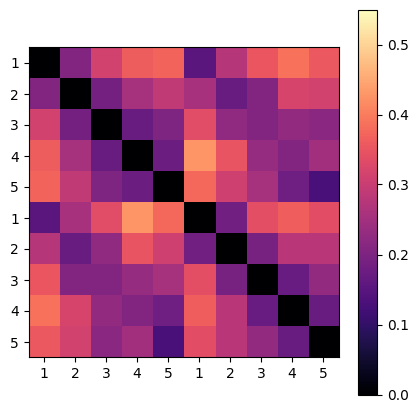

In [29]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

# direction  = {'flex','ext'};    # 1=flexion, 2=extension
# cond_forces= {[1.5 2 2.5],[1 1.5 2]};
# dirTT      = {[1:15],[16:30]};  # condition numbers corresponding to flexion and extension movements
# digitName  = {'thumb','index','middle','fourth','little'};  
# hem        = {'lh','rh'};       # 1 = left hemi (contra) , 2 = right hemi (ipsi)
# regname    = {'S1','M1','PMd','PMv','SMA','V12','SPLa','SPLp'};             # roi names    

# reg_title  = {'Lh S1','Lh M1','Lh PMd','Lh PMv','Lh SMA','Lh V1','Lh SPLa','Lh SPLp',...
#               'Rh S1','Rh M1','Rh PMd','Rh PMv','Rh SMA','Rh V1','Rh SPLa','Rh SPLp'}; 

# load the .mat fMRI file:
mat = scipy.io.loadmat('analysis/EF/ef1_fmri_glm1_reg_betas.mat')
info = scipy.io.loadmat('analysis/EF/SPM_info.mat')

beta_cell = mat['beta']
res_MS_cell = mat['resMS']

# regions:
S1 = 1
M1 = 2
PMd = 3
PMv = 4
SMA = 5
V12 = 6
SPLa = 7
SPLp = 8

# conditions:
run = info['run'].flatten()
digit = info['digitPressed'].flatten()
dir = info['dirPressed'].flatten() # 1: flexion, 2: extension
forcelvl = info['forcelvl'].flatten() # 1: 1.5, 2: 2, 3: 2.5

# voxel info:
sn = mat['SN']
region = mat['region']
N = np.unique(sn).shape[0]

# signal change for flexion/extension + force level + digit:
reg = M1
force = 3

data = []
G_hat = np.zeros((N, 10, 10))
D_hat = np.zeros((N, 10, 10))
# loop on subj:
for i in range(N):
    # data
    beta = beta_cell[(region==reg) & (sn==i+1)][0] / np.sqrt(res_MS_cell[(region==reg) & (sn==i+1)][0])
    beta = beta[:240,:]
    
    # select condition:
    Y = beta[forcelvl==force,:]
    condition = np.tile(np.array([1,2,3,4,5,6,7,8,9,10]),8)
    run_tmp = run[forcelvl==force]
    
    G_hat[i,:,:],_ = pcm.est_G_crossval(Y,condition,run_tmp,X=pcm.matrix.indicator(run_tmp))
    D_hat[i,:,:] = pcm.G_to_dist(G_hat[i,:,:])

# show all second moment matrices
D_hat = np.sqrt(np.abs(D_hat))
vmin = D_hat.min()
vmax = D_hat.max()
plt.figure(figsize=(20,10))
for i in range(N):
    plt.subplot(2,5,i+1)
    plt.imshow(D_hat[i,:,:],vmin=vmin,vmax=vmax,cmap='magma')
    plt.xticks(np.arange(10),['1','2','3','4','5','1','2','3','4','5'])
    plt.yticks(np.arange(10),['1','2','3','4','5','1','2','3','4','5'])

# show the average second moment matrix
plt.figure(figsize=(5,5))
plt.imshow(D_hat.mean(axis=0),vmin=vmin,vmax=0.55,cmap='magma')
plt.xticks(np.arange(10),['1','2','3','4','5','1','2','3','4','5'])
plt.yticks(np.arange(10),['1','2','3','4','5','1','2','3','4','5'])
plt.colorbar()

plt.show()

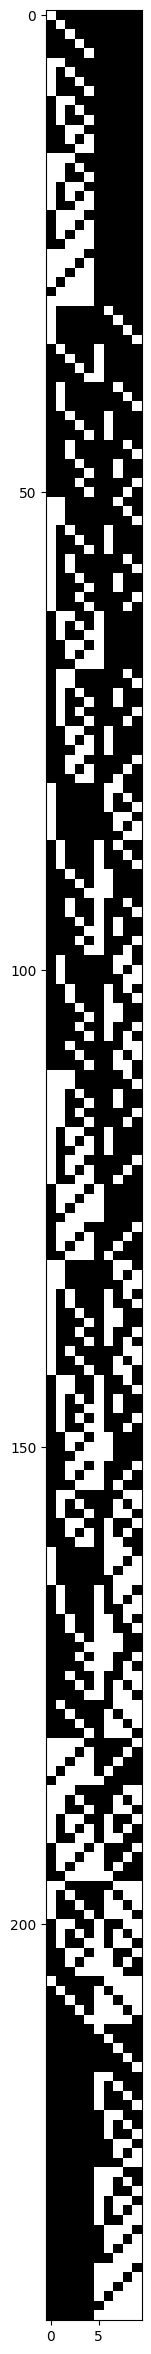

In [15]:
import numpy as np
import PcmPy as pcm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from itertools import permutations

def generate_all_chords():
    # Ali Ghavampour 2024 - alighavam79@gmail.com
    # This function generates all of the possible chords

    comb_pool = [
        [1, 9, 9, 9, 9],  # All the possible combinations of flex-ext-relax. All permutations of each combination makes all possible chords.
        [2, 9, 9, 9, 9],
        [1, 1, 9, 9, 9],
        [1, 2, 9, 9, 9],
        [2, 2, 9, 9, 9],
        [1, 1, 1, 9, 9],
        [1, 1, 2, 9, 9],
        [1, 2, 2, 9, 9],
        [2, 2, 2, 9, 9],
        [1, 1, 1, 1, 9],
        [1, 1, 1, 2, 9],
        [1, 1, 2, 2, 9],
        [1, 2, 2, 2, 9],
        [2, 2, 2, 2, 9],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 2],
        [1, 1, 1, 2, 2],
        [1, 1, 2, 2, 2],
        [1, 2, 2, 2, 2],
        [2, 2, 2, 2, 2]
    ]

    chord_mat = np.array([[9, 9, 9, 9, 9]])  # chords are saved in this matrix (243x5).
    chord_vec = []  # we should turn the 243x5 matrix into a 243x1 string vector for the .tgt files.

    # making a 243x13 matrix of all the possible chords:
    for comb in comb_pool:
        chord_tmp_mat = np.array(list(permutations(comb)))
        chord_mat = np.vstack((chord_mat, np.unique(chord_tmp_mat, axis=0)))

    # change the matrix into a vector -> each row of matrix will become an element of the new vector:
    chord_mat = chord_mat.astype(str)
    for row in chord_mat:
        tmp = ''.join(row)
        tmp = int(tmp)
        chord_vec.append(tmp)

    chord_vec = chord_vec[1:]  # chordVec contains all the possible unique chords other than 99999 (size:242x1) which is all fingers relaxed.
    return chord_vec

def make_design(chord_vec):
    # Ali Ghavampour 2024

    # sort the chords to flexion-only, mixed, and extension-only:
    flex_only = []
    ext_only = []
    mixed = []
    for chord in chord_vec:
        chord_str = str(chord)
        includes_1 = '1' in chord_str
        includes_2 = '2' in chord_str
        if includes_1 and not includes_2:
            flex_only.append(chord)
        elif includes_2 and not includes_1:
            ext_only.append(chord)
        else:
            mixed.append(chord)
    
    sorted_chords = flex_only + mixed + ext_only

    # make the design matrix:
    X = np.zeros((242,10), dtype=int)
    for i,chord in enumerate(sorted_chords):
        chord_str = str(chord)
        # flexion regressors:
        X[i,:5] = [1 if char == '1' else 0 for char in chord_str]
        # extension regressors:
        X[i,5:] = [1 if char == '2' else 0 for char in chord_str]
    
    return X

# Example usage
chord_vec = generate_all_chords()
X = make_design(chord_vec)

# show the design matrix:
plt.figure(figsize=(30,30))
plt.imshow(X, cmap='gray')
plt.show()

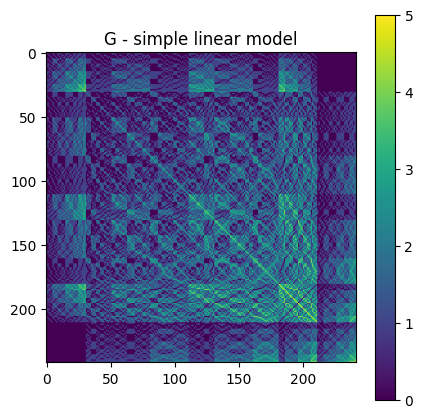

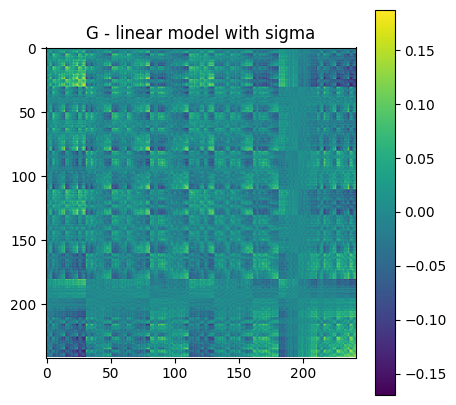

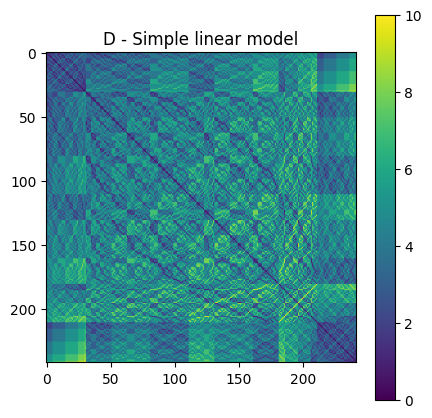

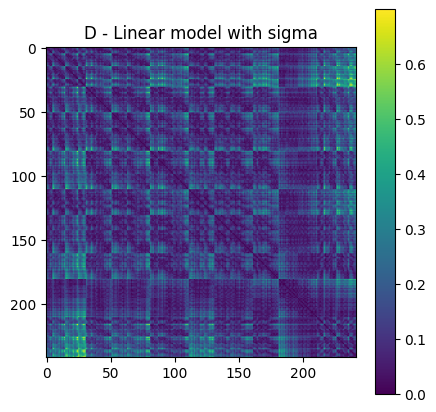

In [21]:
# simple linear model prediction:
G1 = X @ X.T

# linear model with sigma added:
sigma = G_hat.mean(axis=0)
G2 = X @ sigma @ X.T

# show the second moment matrices:
plt.figure(figsize=(5,5))
plt.imshow(G1, cmap='viridis')
plt.colorbar()
plt.title('G - simple linear model')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(G2, cmap='viridis')
plt.colorbar()
plt.title('G - linear model with sigma')
plt.show()


D1 = pcm.G_to_dist(G1)
D2 = pcm.G_to_dist(G2)
# show the second moment matrices:
plt.figure(figsize=(5,5))
plt.imshow(D1, cmap='viridis')
plt.colorbar()
plt.title('D - Simple linear model')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(D2, cmap='viridis')
plt.colorbar()
plt.title('D - Linear model with sigma')
plt.show()